In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
#import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, confusion_matrix, classification_report
#import seaborn as sns
import pycaret
from pycaret.classification import *

# Reading in data
data = pd.read_csv("data_icu.csv")
data = data.rename(columns={"icu_length": "inpatient"})
data = data.drop(columns=['death_inhosp','Mahalanobis','icu_days','age_group','caseid','subjectid'])

In [2]:
# this contains data only on people who spent at least one day in the ICU
data.head()

,Age,Ht,Wt,Sex,OP_time,Open,Robotic,Videoscopic,inpatient
0,18.0,175.1,59.2,0,292.55,1,0,0,1
1,0.7,64.1,8.9,1,475.00,1,0,0,1
2,0.6,42.0,5.6,1,435.00,1,0,0,1
3,0.8,64.1,8.9,1,115.00,1,0,0,1
4,18.0,185.0,62.6,0,210.00,1,0,0,0


# Pycaret

In [3]:
s = setup(data, target = 'inpatient', session_id=3)

,Description,Value
0,session_id,3
1,Target,inpatient
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(1142, 9)"
5,Missing Values,False
6,Numeric Features,4
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


In [4]:
pycaret.__version__

'2.3.10'

In [5]:
exp1 = setup(data, target='inpatient')

,Description,Value
0,session_id,404
1,Target,inpatient
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(1142, 9)"
5,Missing Values,False
6,Numeric Features,4
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


In [6]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7246,0.7376,0.3833,0.5626,0.4502,0.2775,0.2889,0.0420
ridge,Ridge Classifier,0.7234,0.0000,0.2583,0.5606,0.3486,0.2111,0.2344,0.0050
lda,Linear Discriminant Analysis,0.7172,0.7493,0.3292,0.5432,0.4038,0.2370,0.2512,0.0070
rf,Random Forest Classifier,0.7171,0.7327,0.4042,0.5446,0.4595,0.2747,0.2825,0.2150
et,Extra Trees Classifier,0.7159,0.7417,0.3917,0.5425,0.4472,0.2654,0.2748,0.2140
ada,Ada Boost Classifier,0.7158,0.7267,0.3917,0.5390,0.4483,0.2654,0.2737,0.0370
lr,Logistic Regression,0.7134,0.7472,0.2708,0.5272,0.3523,0.1990,0.2164,0.6920
lightgbm,Light Gradient Boosting Machine,0.7045,0.7171,0.4042,0.5104,0.4463,0.2508,0.2557,0.1230
dummy,Dummy Classifier,0.6996,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0050
knn,K Neighbors Classifier,0.6721,0.6060,0.2458,0.4351,0.3064,0.1150,0.1262,0.0680


In [7]:
print(best)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=404, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


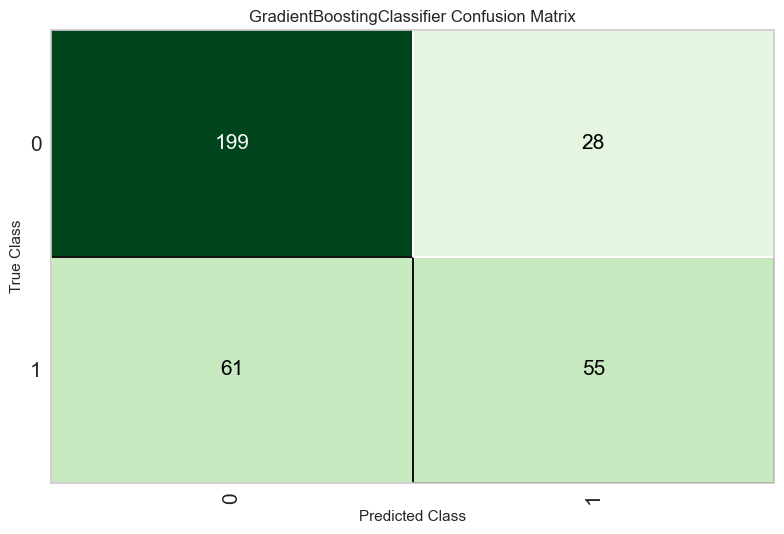

In [8]:
plot_model(best, plot='confusion_matrix')

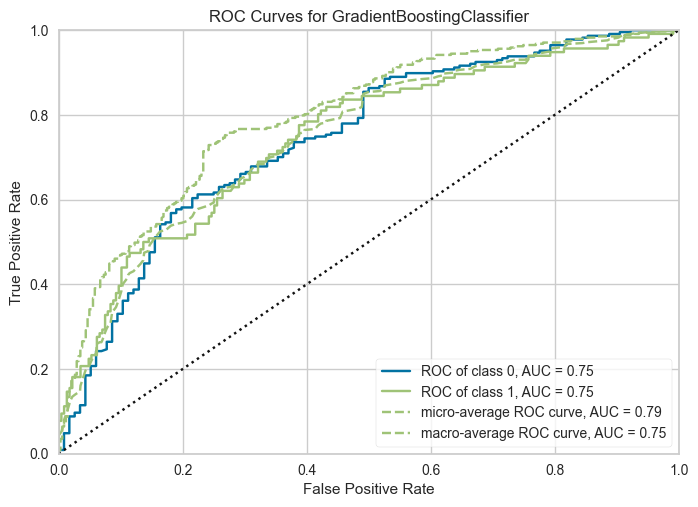

In [9]:
plot_model(best, plot='auc')

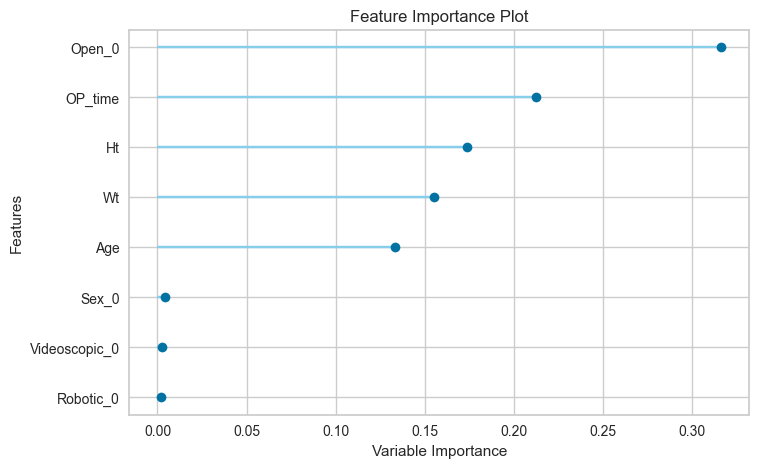

In [10]:
plot_model(best, plot='feature')

# Multiple Linear Regression

For this section, we will only consider people who did have ICU stays and will predict the number of days their stay lasted.

There are 913 training instances and 229 testing instances


(array([190.,  19.,  10.,   1.,   1.,   1.,   5.,   0.,   1.,   1.]),
 array([ 1. ,  3.5,  6. ,  8.5, 11. , 13.5, 16. , 18.5, 21. , 23.5, 26. ]),
 <BarContainer object of 10 artists>)

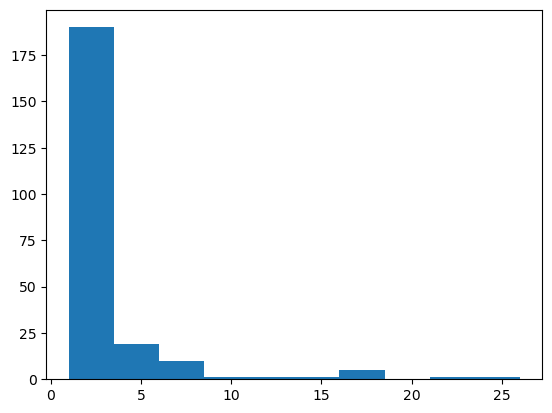

In [3]:
# select the relevant variables
X_ml = data[['Age', 'Ht', 'Wt', 'Sex', 'OP_time', 'Open', 'Robotic', 'Videoscopic']]
y_ml = data['icu_days']

# test/train split
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(X_ml, y_ml, test_size=0.2, random_state=10)

print(f'There are {len(y_train_ml)} training instances and {len(y_test_ml)} testing instances')

# train the model and make predictions
model_ml = LinearRegression()
model_ml.fit(X_train_ml, y_train_ml)
y_prediction_ml = model_ml.predict(X_test_ml)

plt.figure()
plt.hist(y_test_ml)

The feature variables explain -20.33223988732167% of the variance in number of ICU days
The root mean squared error is 3.7915072996013865


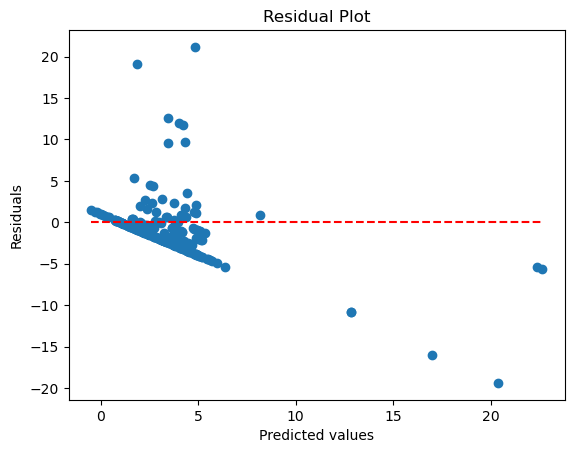

In [4]:
# Coefficient of Determination (R²):
# R² explains the proportion of variance in the target variable that is explained by the predictors.
r2_ml = r2_score(y_test_ml, y_prediction_ml)
print(f'The feature variables explain {100*r2_ml}% of the variance in number of ICU days')

rmse_ml = mean_squared_error(y_test_ml, y_prediction_ml, squared = False)
print(f'The root mean squared error is {rmse_ml}')

# plotting residuals
residuals_ml = y_test_ml - y_prediction_ml
plt.scatter(y_prediction_ml, residuals_ml)
plt.hlines(0, min(y_prediction_ml), max(y_prediction_ml), colors="r", linestyles="dashed")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

# Logistic Regression (ICU)

Predict whether or not someone will have long or short ICU stay.

In [5]:
X_lr_icu = data[['Age', 'Ht', 'Wt', 'Sex', 'OP_time', 'Open', 'Robotic', 'Videoscopic']]
y_lr_icu = data['icu_length']

X_train_lr_icu, X_test_lr_icu, y_train_lr_icu, y_test_lr_icu = train_test_split(X_lr_icu, y_lr_icu, test_size=0.2, random_state=42)
print(f'There are {len(y_train_lr_icu)} training instances and {len(y_test_lr_icu)} testing instances')

# train the model and make predictions
model_lr_icu = LogisticRegression(class_weight="balanced", solver='liblinear', random_state=42)
model_lr_icu.fit(X_train_lr_icu, y_train_lr_icu)
y_prediction_lr_icu = model_lr_icu.predict(X_test_lr_icu)

There are 913 training instances and 229 testing instances


In [6]:
accuracy_icu = accuracy_score(y_test_lr_icu, y_prediction_lr_icu)
print("Accuracy:", accuracy_icu)

# Classification Report
print("Classification Report:\n", classification_report(y_test_lr_icu, y_prediction_lr_icu))

Accuracy: 0.6986899563318777
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.63      0.73       146
           1       0.56      0.82      0.66        83

    accuracy                           0.70       229
   macro avg       0.71      0.72      0.70       229
weighted avg       0.75      0.70      0.70       229



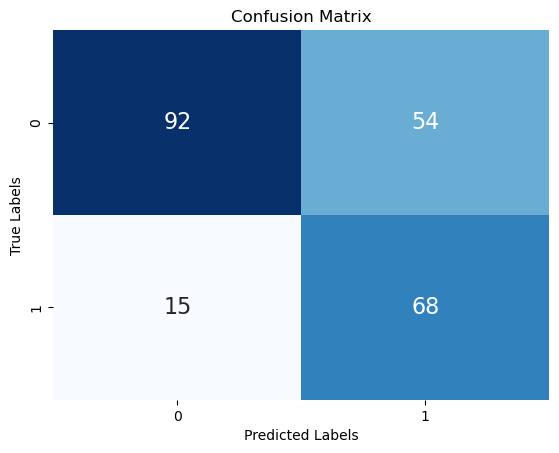

In [7]:
# confusion matrix visualization

cm_icu = confusion_matrix(y_test_lr_icu, y_prediction_lr_icu)

plt.figure()
sns.heatmap(cm_icu, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Logistic Regression (Mortality)

In [8]:
X_lr_mor = data[['Age', 'Ht', 'Wt', 'Sex', 'OP_time', 'Open', 'Robotic', 'Videoscopic']]
y_lr_mor = data['death_inhosp']

X_train_lr_mor, X_test_lr_mor, y_train_lr_mor, y_test_lr_mor = train_test_split(X_lr_mor, y_lr_mor, test_size=0.2, random_state=42)
print(f'There are {len(y_train_lr_mor)} training instances and {len(y_test_lr_mor)} testing instances')

# train the model and make predictions
model_lr_mor = LogisticRegression(solver='liblinear', random_state=42)
model_lr_mor.fit(X_train_lr_mor, y_train_lr_mor)
y_prediction_lr_mor = model_lr_mor.predict(X_test_lr_mor)

There are 913 training instances and 229 testing instances


Accuracy: 0.9563318777292577
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       219
           1       0.00      0.00      0.00        10

    accuracy                           0.96       229
   macro avg       0.48      0.50      0.49       229
weighted avg       0.91      0.96      0.93       229

Confusion Matrix:
 [[219   0]
 [ 10   0]]


/Users/dylanmack/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dylanmack/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dylanmack/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


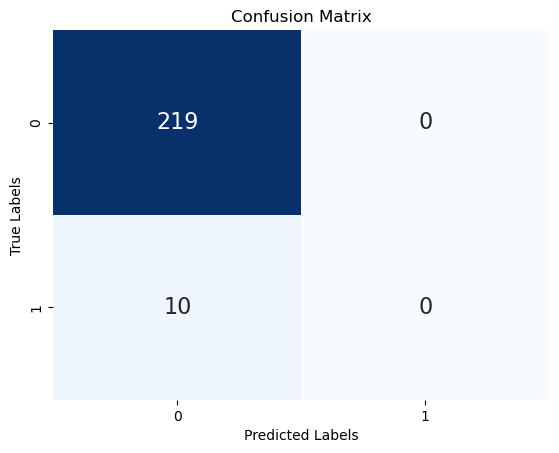

In [9]:
accuracy_mor = accuracy_score(y_test_lr_mor, y_prediction_lr_mor)
print("Accuracy:", accuracy_mor)

# Classification Report
print("Classification Report:\n", classification_report(y_test_lr_mor, y_prediction_lr_mor))
print("Confusion Matrix:\n", confusion_matrix(y_test_lr_mor, y_prediction_lr_mor))


cm_mor = confusion_matrix(y_test_lr_mor, y_prediction_lr_mor)
plt.figure()
sns.heatmap(cm_mor, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Accuracy: 0.6986899563318777
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.69      0.82       219
           1       0.11      0.80      0.19        10

    accuracy                           0.70       229
   macro avg       0.55      0.75      0.50       229
weighted avg       0.95      0.70      0.79       229



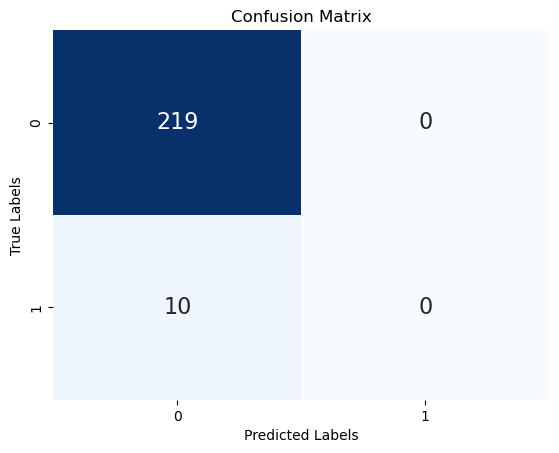

In [10]:
# Again but weight towards minority class

model_lr_mor = LogisticRegression(class_weight="balanced", solver='liblinear', random_state=42)
model_lr_mor.fit(X_train_lr_mor, y_train_lr_mor)
y_prediction_lr_mor = model_lr_mor.predict(X_test_lr_mor)

accuracy_mor = accuracy_score(y_test_lr_mor, y_prediction_lr_mor)
print("Accuracy:", accuracy_mor)

# Classification Report
print("Classification Report:\n", classification_report(y_test_lr_mor, y_prediction_lr_mor))

cm_mor2 = confusion_matrix(y_test_lr_mor, y_prediction_lr_mor)
plt.figure()
sns.heatmap(cm_mor, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Random Forest (ICU)

There are 913 training instances and 229 testing instances
Accuracy: 0.74235807860262
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.86      0.81       146
           1       0.69      0.53      0.60        83

    accuracy                           0.74       229
   macro avg       0.73      0.70      0.70       229
weighted avg       0.74      0.74      0.73       229



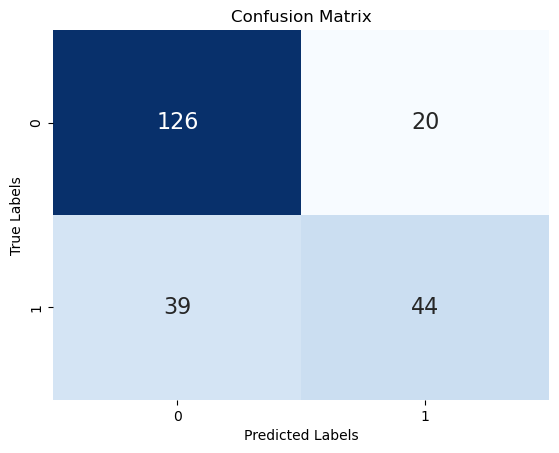

In [11]:
X_rf_icu = data[['Age', 'Ht', 'Wt', 'Sex', 'OP_time', 'Open', 'Robotic', 'Videoscopic']]
y_rf_icu = data['icu_length']

X_train_rf_icu, X_test_rf_icu, y_train_rf_icu, y_test_rf_icu = train_test_split(X_rf_icu, y_rf_icu, test_size=0.2, random_state=42)
print(f'There are {len(y_train_rf_icu)} training instances and {len(y_test_rf_icu)} testing instances')

clf_icu = RandomForestClassifier(n_estimators=100, random_state=42)
clf_icu.fit(X_train_rf_icu, y_train_rf_icu)

y_pred_rf_icu = clf_icu.predict(X_test_rf_icu)



accuracy_rf_icu = accuracy_score(y_test_rf_icu, y_pred_rf_icu)
print("Accuracy:", accuracy_rf_icu)

# Classification Report
print("Classification Report:\n", classification_report(y_test_rf_icu, y_pred_rf_icu))

cm_rf_icu = confusion_matrix(y_test_rf_icu, y_pred_rf_icu)

plt.figure()
sns.heatmap(cm_rf_icu, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# XGBoost (ICU)

There are 913 training instances and 229 testing instances
Accuracy: 0.6943231441048034
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.82      0.77       146
           1       0.60      0.47      0.53        83

    accuracy                           0.69       229
   macro avg       0.67      0.65      0.65       229
weighted avg       0.68      0.69      0.68       229



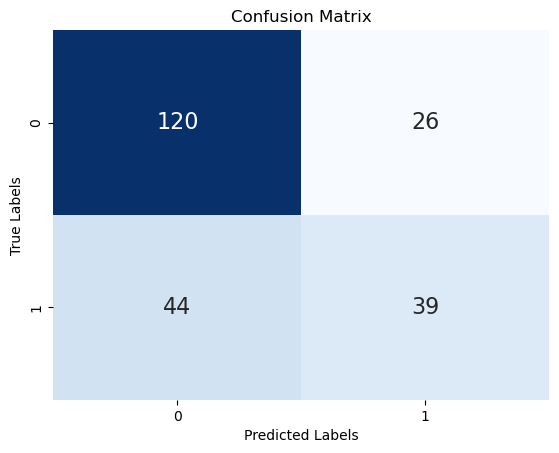

In [12]:
X_xgb_icu = data[['Age', 'Ht', 'Wt', 'Sex', 'OP_time', 'Open', 'Robotic', 'Videoscopic']]
y_xgb_icu = data['icu_length']

X_train_xgb_icu, X_test_xgb_icu, y_train_xgb_icu, y_test_xgb_icu = train_test_split(X_xgb_icu, y_xgb_icu, test_size=0.2, random_state=42)
print(f'There are {len(y_train_xgb_icu)} training instances and {len(y_test_xgb_icu)} testing instances')

xgb_icu = xgb.XGBClassifier()
xgb_icu.fit(X_train_xgb_icu, y_train_xgb_icu)

y_pred_xgb_icu = xgb_icu.predict(X_test_xgb_icu)



accuracy_xgb_icu = accuracy_score(y_test_xgb_icu, y_pred_xgb_icu)
print("Accuracy:", accuracy_xgb_icu)

# Classification Report
print("Classification Report:\n", classification_report(y_test_xgb_icu, y_pred_xgb_icu))

cm_xgb_icu = confusion_matrix(y_test_xgb_icu, y_pred_xgb_icu)

plt.figure()
sns.heatmap(cm_xgb_icu, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# XGBoost Regression (Length of ICU Stay)

There are 913 training instances and 229 testing instances


(array([190.,  19.,  10.,   1.,   1.,   1.,   5.,   0.,   1.,   1.]),
 array([ 1. ,  3.5,  6. ,  8.5, 11. , 13.5, 16. , 18.5, 21. , 23.5, 26. ]),
 <BarContainer object of 10 artists>)

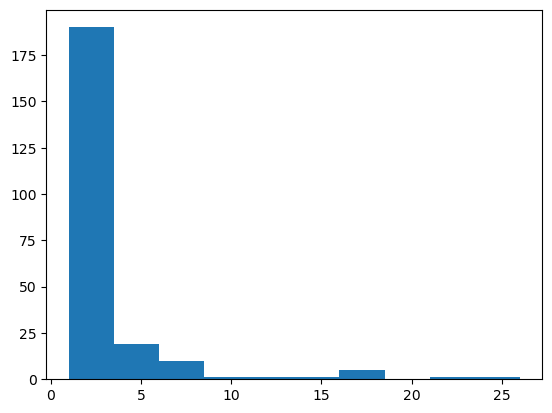

In [13]:
# select the relevant variables
X_xgb_licu = data[['Age', 'Ht', 'Wt', 'Sex', 'OP_time', 'Open', 'Robotic', 'Videoscopic']]
y_xgb_licu = data['icu_days']

# test/train split
X_train_xgb_licu, X_test_xgb_licu, y_train_xgb_licu, y_test_xgb_licu = train_test_split(X_xgb_licu, y_xgb_licu, test_size=0.2, random_state=10)

print(f'There are {len(y_train_xgb_licu)} training instances and {len(y_test_xgb_licu)} testing instances')

# train the model and make predictions
xgb_licu = xgb.XGBRegressor()
xgb_licu.fit(X_train_xgb_licu, y_train_xgb_licu)

y_pred_xgb_licu = xgb_licu.predict(X_test_xgb_licu)

plt.figure()
plt.hist(y_test_xgb_licu)

The feature variables explain -389.212094052777% of the variance in number of ICU days
The root mean squared error is 7.644859153090583


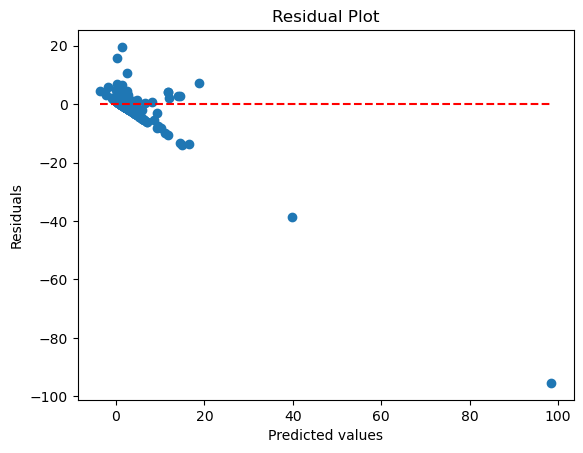

In [14]:
# Coefficient of Determination (R²):
# R² explains the proportion of variance in the target variable that is explained by the predictors.
r2_xgb_licu = r2_score(y_test_xgb_licu, y_pred_xgb_licu)
print(f'The feature variables explain {100*r2_xgb_licu}% of the variance in number of ICU days')

rmse_xgb_licu = mean_squared_error(y_test_xgb_licu, y_pred_xgb_licu, squared = False)
print(f'The root mean squared error is {rmse_xgb_licu}')

# plotting residuals
residuals_xgb_licu = y_test_xgb_licu - y_pred_xgb_licu
plt.scatter(y_pred_xgb_licu, residuals_xgb_licu)
plt.hlines(0, min(y_pred_xgb_licu), max(y_pred_xgb_licu), colors="r", linestyles="dashed")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

In [ ]:
# Run everything through pycarat and sci-kit learn